# Interpolate ERA5 pressure level data to 1 deg

In [1]:
import os
import sys
import yaml
import dask
import zarr
import numpy as np
import xarray as xr
from glob import glob

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import xesmf as xe

In [4]:
sys.path.insert(0, os.path.realpath('../libs/'))
import interp_utils as iu

## Vertical level subsetting

In [19]:
config_name = os.path.realpath('data_config_6h.yml')

with open(config_name, 'r') as stream:
    conf = yaml.safe_load(stream)

year = 1979 # test on one year

In [20]:
level_sub = [1, 50, 150, 200, 250, 300, 400, 500, 600, 700, 850, 925, 1000]
conf['zarr_opt']['chunk_size_4d_1deg']['level'] = len(level_sub)

base_dir_1deg = conf['zarr_opt']['save_loc_1deg']

year = 1980

name_full_level = base_dir_1deg + 'all_in_one/ERA5_plevel_1deg_6h_{}_conserve.zarr'.format(year)


ds_full = xr.open_zarr(name_full_level)
subset_inds = [np.where(ds_full['level'].values == val)[0][0] for val in level_sub]
ds_sub = ds_full.isel(level=subset_inds)


# ========================================================================== #
# chunking
varnames = list(ds_sub.keys())
varname_4D = ['U', 'V', 'T', 'Z', 'Q', 'specific_total_water']

for i_var, var in enumerate(varnames):
    if var in varname_4D:
        ds_sub[var] = ds_sub[var].chunk(conf['zarr_opt']['chunk_size_4d_1deg'])
    else:
        ds_sub[var] = ds_sub[var].chunk(conf['zarr_opt']['chunk_size_3d_1deg'])

# zarr encodings
dict_encoding = {}

chunk_size_3d = dict(chunks=(conf['zarr_opt']['chunk_size_3d_1deg']['time'],
                             conf['zarr_opt']['chunk_size_3d_1deg']['latitude'],
                             conf['zarr_opt']['chunk_size_3d_1deg']['longitude']))

chunk_size_4d = dict(chunks=(conf['zarr_opt']['chunk_size_4d_1deg']['time'],
                             conf['zarr_opt']['chunk_size_4d_1deg']['level'],
                             conf['zarr_opt']['chunk_size_4d_1deg']['latitude'],
                             conf['zarr_opt']['chunk_size_4d_1deg']['longitude']))

compress = zarr.Blosc(cname='zstd', clevel=1, shuffle=zarr.Blosc.SHUFFLE, blocksize=0)

for i_var, var in enumerate(varnames):
    if var in varname_4D:
        dict_encoding[var] = {'compressor': compress, **chunk_size_4d}
    else:
        dict_encoding[var] = {'compressor': compress, **chunk_size_3d}

# ========================================================================== #
save_name = base_dir_1deg + 'upper_subset/ERA5_subset_1deg_6h_{}_conserve.zarr'.format(year)
# ds_sub.to_zarr(save_name, mode='w', consolidated=True, compute=True, encoding=dict_encoding)

In [30]:
ds_full['level'].values

array([   1.,    2.,    3.,    5.,    7.,   10.,   20.,   30.,   50.,
         70.,  100.,  125.,  150.,  175.,  200.,  225.,  250.,  300.,
        350.,  400.,  450.,  500.,  550.,  600.,  650.,  700.,  750.,
        775.,  800.,  825.,  850.,  875.,  900.,  925.,  950.,  975.,
       1000.], dtype=float32)

### static & physics file

In [5]:
config_name = os.path.realpath('data_config_6h.yml')

with open(config_name, 'r') as stream:
    conf = yaml.safe_load(stream)

In [6]:
base_dir_1deg = conf['zarr_opt']['save_loc_1deg']
base_dir = conf['ARCO']['save_loc'] + 'static/' 
static_name = base_dir + conf['ARCO']['prefix'] + '_static.zarr'

In [7]:
ds_static = xr.open_zarr(static_name)

In [8]:
# ================================================================================== #
# geopotential at surface
lon_1deg = np.arange(0, 360, 1)
lat_1deg = np.arange(-90, 91, 1)
target_grid = iu.Grid.from_degrees(lon_1deg, lat_1deg)

lon_025deg = ds_static['longitude'].values
lat_025deg = ds_static['latitude'].values[::-1]
source_grid = iu.Grid.from_degrees(lon_025deg, lat_025deg)

regridder = iu.ConservativeRegridder(source=source_grid, target=target_grid)

ds_static = ds_static.chunk({'longitude': -1, 'latitude': -1})
ds_static_1deg = regridder.regrid_dataset(ds_static)

for var in ds_static_1deg.data_vars:
    # Get the current dimensions of the variable
    current_dims = ds_static_1deg[var].dims
    
    # If both 'latitude' and 'longitude' are present, reorder them
    if 'latitude' in current_dims and 'longitude' in current_dims:
        # New order: move 'latitude' and 'longitude' to the first two positions, preserve other dimensions
        new_order = [dim for dim in current_dims if dim not in ['latitude', 'longitude']] + ['latitude', 'longitude']
        
        # Transpose the variable to the new order
        ds_static_1deg[var] = ds_static_1deg[var].transpose(*new_order)

lon_1deg = np.arange(0, 360, 1)
lat_1deg = np.arange(-90, 91, 1)

# Add latitude and longitude as coordinates to ds_static_1deg
ds_static_1deg = ds_static_1deg.assign_coords({
    'latitude': lat_1deg,
    'longitude': lon_1deg
})

# flip latitude from -90 --> 90 to 90 --> -90
ds_static_1deg = ds_static_1deg.isel(latitude=slice(None, None, -1))

# ================================================================================== #
# normalized geopotential at surface

# normalize 'geopotential_at_surface
mean_val = float(ds_static_1deg['geopotential_at_surface'].mean(skipna=False))
std_val = float(ds_static_1deg['geopotential_at_surface'].std(skipna=False))
z_norm = (ds_static_1deg['geopotential_at_surface'] - mean_val)/std_val
ds_static_1deg['z_norm'] = z_norm

# ======================================================================================= #
# process land-sea mask and sea ice
land_sea_mask = ds_static['land_sea_mask']

# Define the target 1-degree grid
lon_1deg = np.arange(0, 360, 1)
lat_1deg = np.arange(-90, 91, 1)[::-1]

# Create target grid as an xarray Dataset
ds_out = xr.Dataset(
    {
        'latitude': (['latitude'], lat_1deg),
        'longitude': (['longitude'], lon_1deg)
    }
)

# Create the regridder object for bilinear interpolation
regridder = xe.Regridder(ds_static, ds_out, 'nearest_s2d')

# Apply the regridding to interpolate all variables
land_sea_mask_1deg = regridder(land_sea_mask)
ds_static_1deg['land_sea_mask'] = land_sea_mask_1deg

# ======================================================================================= #
# process soil type
soil_type = ds_static['soil_type']

soil_type_1deg = regridder(soil_type)
ds_static_1deg['soil_type'] = soil_type_1deg

# ================================================================================== #
# physics variables

# lon1d and lat1d are 1D
lon1d = ds_static_1deg['longitude'].values
lat1d = ds_static_1deg['latitude'].values

# Generate 2D latitude and longitude arrays
lon2d, lat2d = np.meshgrid(lon1d, lat1d)

# Define pressure levels (p_level) as a new dimension
# level_sub = [1, 100, 150, 200, 250, 300, 400, 500, 600, 700, 850, 925, 1000]
p_level = np.array([   100.,   5000.,  15000.,  20000.,  25000.,  30000.,
                     40000.,  50000.,  60000.,  70000.,  85000.,  92500., 100000.])

# Add 2D longitude and latitude arrays to the dataset
ds_static_1deg['lon2d'] = xr.DataArray(lon2d, dims=('latitude', 'longitude'))
ds_static_1deg['lat2d'] = xr.DataArray(lat2d, dims=('latitude', 'longitude'))

# get plevel coordiante from upper air
ds_example = xr.open_zarr(
    '/glade/derecho/scratch/ksha/CREDIT_data/ERA5_plevel_1deg/upper_subset/ERA5_subset_1deg_6h_1979_conserve.zarr'
)

# Add pressure levels as a new variable with its own dimension
ds_static_1deg['p_level'] = xr.DataArray(p_level, dims=('level'))
ds_static_1deg = ds_static_1deg.assign_coords(level=('level', p_level))

# ================================================================================== #
# float64 --> float32
ds_static_1deg = ds_static_1deg.astype({var: np.float32 for var in ds_static_1deg})

# Convert latitude, longitude, and level coordinates to float32
ds_static_1deg = ds_static_1deg.assign_coords({
    'latitude': ds_example['latitude'],
    'longitude': ds_example['longitude'],
    'level': ds_example['level']
})

# ================================================================================== #
# chunk
varnames = list(ds_static_1deg.keys())
varnames = varnames[:-1] # subtract 'level'

for i_var, var in enumerate(varnames):
    ds_static_1deg[var] = ds_static_1deg[var].chunk({'latitude': 181, 'longitude': 360})

# zarr encodings
dict_encoding = {}

chunk_size_2d = dict(chunks=(conf['zarr_opt']['chunk_size_3d_1deg']['latitude'],
                             conf['zarr_opt']['chunk_size_3d_1deg']['longitude']))

compress = zarr.Blosc(cname='zstd', clevel=1, shuffle=zarr.Blosc.SHUFFLE, blocksize=0)

for i_var, var in enumerate(varnames):
    dict_encoding[var] = {'compressor': compress, **chunk_size_2d}

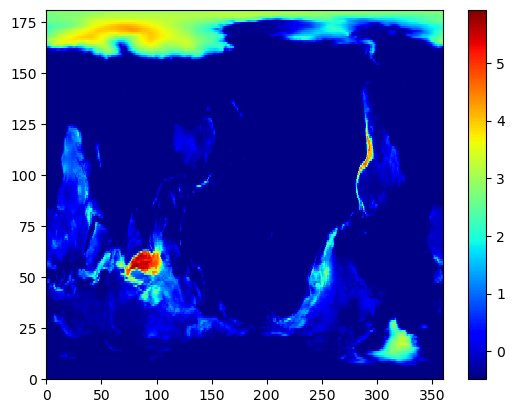

In [9]:
plt.pcolormesh(ds_static_1deg['z_norm'].values, cmap=plt.cm.jet)
plt.colorbar()

In [11]:
save_name = base_dir_1deg + 'static/ERA5_plevel_1deg_6h_subset_static.zarr'
# ds_static_1deg.to_zarr(save_name, mode='w', consolidated=True, compute=True, encoding=dict_encoding)

In [11]:
save_name

'/glade/derecho/scratch/ksha/CREDIT_data/ERA5_plevel_1deg/static/ERA5_plevel_1deg_6h_subset_static.zarr'

In [12]:
ds_static_1deg

<xarray.Dataset>
Dimensions:                  (latitude: 181, longitude: 360, level: 14)
Coordinates:
  * latitude                 (latitude) float32 90.0 89.0 88.0 ... -89.0 -90.0
  * longitude                (longitude) float32 0.0 1.0 2.0 ... 358.0 359.0
  * level                    (level) float32 1.0 50.0 100.0 ... 925.0 1e+03
Data variables:
    geopotential_at_surface  (latitude, longitude) float32 dask.array<chunksize=(181, 360), meta=np.ndarray>
    land_sea_mask            (latitude, longitude) float32 dask.array<chunksize=(181, 360), meta=np.ndarray>
    soil_type                (latitude, longitude) float32 dask.array<chunksize=(181, 360), meta=np.ndarray>
    z_norm                   (latitude, longitude) float32 dask.array<chunksize=(181, 360), meta=np.ndarray>
    lon2d                    (latitude, longitude) float32 dask.array<chunksize=(181, 360), meta=np.ndarray>
    lat2d                    (latitude, longitude) float32 dask.array<chunksize=(181, 360), meta=np.ndarray>
    p_level                  (level) float32 100.0 5e+03 ... 9.25e+04 1e+05